
# BBC News Classification
<p>CSCA-5632 Unsupervised Algorithms in Machine Learning</p>
<p>University of Colorado Boulder</p>
<p>@author alme9155@colorado.edu</p>
<hr/>

## I. Project Overview:
### This class project categorizes news articles using matrix factorization to predict the categories. 

This notebook includes the following:
* Brief EDA procedures
* Matrix factorization model building and training
* Model predictions and results
* Prediction results comparison with Supervised Learning

### Description
This project will use a public dataset from the BBC comprised of 2225 articles, each labeled under one of the five categories: business, entertainment, politics, sport, or tech. It is a balanced dataset that. Each category has about 400~500 articles, which ensures meaningful classification.

<ul>
<li>Data source: <a url="https://kaggle.com/competitions/learn-ai-bbc">https://kaggle.com/competition/learn-ai-bbc</a></li>
<li>Bijoy Bose. BBC News Classification</li>
<li>year: 2019</li>
</ul>

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input/learn-ai-bbc'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


## II. Exploratory Data Analysis

**II.i.** Loading the data from Kaggle competition
This notebook require internet connection to download dataset from the kaggle competition.

**II.ii.** Exploring and understanding the data

In [2]:
# EDA process
# 1. load the dataset
# 2. inspect the data

## loading the data
train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
print(f"Data loaded successfully.")

print(f"\nTraining Data Info:")
print("--------------------------")
print(train.info())
print(f"\nTesting Data Info:")
print("--------------------------")    
print(test.info())

print(f"\nFirst five rows of training data:")
print("--------------------------")    
print(train.head())
print(f"\nFirst five rows of testing data:")
print("--------------------------")    
print(test.head())

print(f"\nMissing values in Training Set:")
print("--------------------------")    
print(train.isnull().sum())
print(f"\nMissing Values in Test Set:")
print("--------------------------")    
print(test.isnull().sum())




Data loaded successfully.

Training Data Info:
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None

Testing Data Info:
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None

First five rows of training data:
--------------------------
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  busin

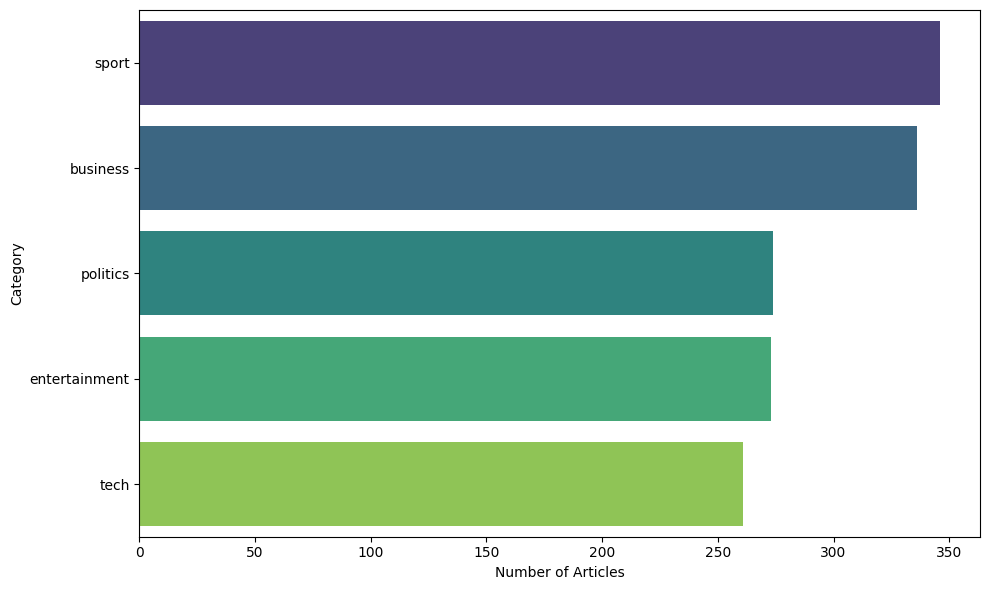

In [3]:
# here is a bar chart of the count of text category
category_count = train["Category"].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(y=category_count.index, x=category_count.values, palette='viridis')
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


### Cleaning the data 
it is necessary to 